# Bayesian inference tutorial

***This notebook is not complete!***

In this tutorial, we will illustrate an example of Bayesian parameter inference using **appoximate Bayesian computation (ABC)** as an alternative to **Markov chain Monte Carlo (MCMC)**. We will use the following Julia packages:

In [1]:
using LinearAlgebra
using Random, Distributions, Turing    #, GpABC (not working...)
using Catalyst, DifferentialEquations
using Plots, LaTeXStrings

## Mathematical model

The motivating application here is the first problem in [Pooley et al., 2015](https://royalsocietypublishing.org/doi/10.1098/rsif.2015.0225). To summarize, we have a compartmental epidemiological model with susceptible (S) and infected (I) compartments. The model parameters are a second-order infection rate $\alpha$ and a first-order recovery rate $\beta$.

$$
\begin{align}
\text{S} + \text{I} &\xrightarrow{\alpha} \text{I}\\
\text{I} &\xrightarrow{\beta} \text{S}
\end{align}\label{eq:sis}\tag{1}
$$

This is known as an **SIS model**, and mathematically, both equations can be thought of as an inhomogeneous Poisson process with rates $\alpha I(t)S(t)$ and $\beta I(t)$, respectively. We will run the model as a **continuous-time Markov chain (CTMC)** (not to be confused with the completely unrelated "Markov chain" in MCMC!!!), meaning that discrete jumps in the number of S and I can happen at any continuous $t\in T$.

In [2]:
sis = @reaction_network begin
    α, S + I --> 2I
    β, I --> S
end α β

Model ##ReactionSystem#302 with 2 equations
States (2):
  S(t)
  I(t)
Parameters (2):
  α
  β

Sometimes, it's nice to have a graphical representation of our SIS model. Here is a Petri net of Eq. ([1](#mjx-eqn-eq:sis)) with species in blue and reactions in orange:

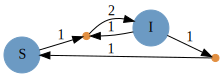

In [3]:
Graph(sis)

For concreteness, we will set the parameters $\theta := (\alpha,\beta) = (0.003,0.1)$ and run the model in the time domain $T := [t_0,t_f] = [0,100]$ starting from the initial counts $u(0) =: u_0 = (100,1)$.

In [4]:
α,β = 0.003,0.1
θ = (:α => α,:β => β)
t0,tf = 0.0,100
tspan = (t0,tf)
u0 = [:S => 100,:I => 1]

2-element Vector{Pair{Symbol, Int64}}:
 :S => 100
 :I => 1

## Data generation

To generate some data for our inference problem, let us now simulate one trajectory of model ([1](#mjx-eqn-eq:sis)) using the DifferentialEquations package (the random seeding is merely for reproducibility):

In [5]:
Random.seed!(1234)
dprob = DiscreteProblem(sis,u0,tspan,θ)
jprob = JumpProblem(sis,dprob,Direct())
u = solve(jprob,SSAStepper())

retcode: Default
Interpolation: Piecewise constant interpolation
t: 1016-element Vector{Float64}:
   0.0
   5.171831817588384
   9.555053856338008
   9.738536149708478
   9.824279738672269
  10.488644136883249
  10.814091439154161
  11.072614678553894
  11.843400040427074
  12.092797470682802
  12.15107417125454
  12.967914703821387
  13.623640012369133
   ⋮
  99.2858146656531
  99.41026428960525
  99.48440577471924
  99.50636030871243
  99.65021175346642
  99.66801001773416
  99.7281558433621
  99.78953004844692
  99.91662482782411
  99.93096201159872
  99.9610130245312
 100.0
u: 1016-element Vector{Vector{Int64}}:
 [100, 1]
 [99, 2]
 [98, 3]
 [97, 4]
 [96, 5]
 [97, 4]
 [96, 5]
 [97, 4]
 [98, 3]
 [97, 4]
 [96, 5]
 [95, 6]
 [94, 7]
 ⋮
 [36, 65]
 [35, 66]
 [34, 67]
 [35, 66]
 [36, 65]
 [37, 64]
 [38, 63]
 [39, 62]
 [38, 63]
 [39, 62]
 [38, 63]
 [38, 63]

From this trajectory $u$, we will generate $n$ observations at times $(t_i)_{i=1}^n$ using the following algorithm:

- Sample the latent (i.e., unobserved) variables $x := (u(t_i))_{i=1}^n$
- Compute the observations (data) $y=(y_i)_i^n$ using the linear forward model
$$
\begin{align*}
y_i &= Gx_i + \eta_i\\
&= \begin{pmatrix}0&1\end{pmatrix} \begin{pmatrix}x_S^{(i)}\\x_I^{(i)}\end{pmatrix} + \eta_i,
\end{align*}
$$
where $\eta_i\stackrel{\text{i.i.d.}}{\sim}\mathcal{N}(0,\sigma^2)$. (All this just means that only $I(t)$ is noisily observed.)

Let's plot the sample trajectory $u$, the latent variables $x$, and the observations $y$.

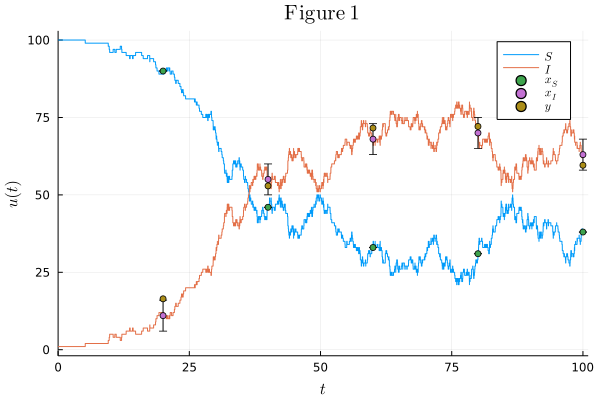

In [6]:
n = 5
t = collect(range(20,tf,n))
x = hcat(u.(t)...)
σ = 5
y = max.(x[2,:] + rand(Normal(0,σ),n),0)

fig1 = plot(u,xlabel=L"t",ylabel=L"u(t)",label=[L"S" L"I"],fmt=:png)
fig1 = scatter!(t,x',yerror=[0 σ],label=[L"x_S" L"x_I"],xlims=(0,tf+1))
fig1 = scatter!(t,y,label=L"y",title=L"\textrm{Figure\ 1}")

## Bayesian inference

Now imagine that we are given the noisy data points $y$ of infected individuals and know nothing about the parameters $\theta$ that generated it. How do we go about getting a good estimation $\hat\theta$?

$$
p(\theta\vert y) \propto \underbrace{p(y\vert x,\theta)}_{\substack{\text{measurement}\\\text{error}}}\,\underbrace{p(x\vert\theta)}_{\substack{\text{likelihood}\\\mathcal{L}(\theta;x)}}\,\underbrace{p(\theta)}_\text{prior}
$$

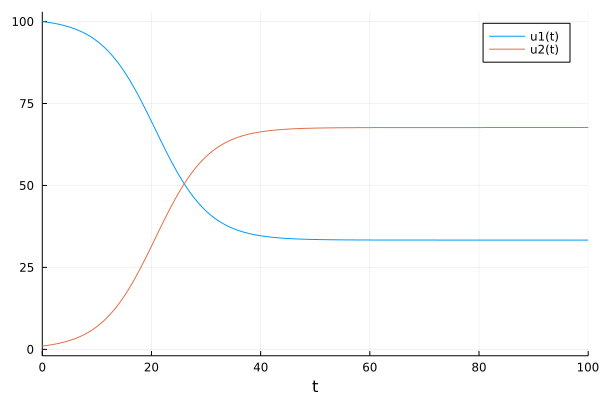

In [7]:
f(U,θ,t) = [-θ.α*U[1]*U[2] + θ.β*U[2];θ.α*U[1]*U[2] - θ.β*U[2]]
oprob = ODEProblem(f,last.(u0),tspan,NamedTuple(θ))
U = solve(oprob)

plot(U,fmt=:png)

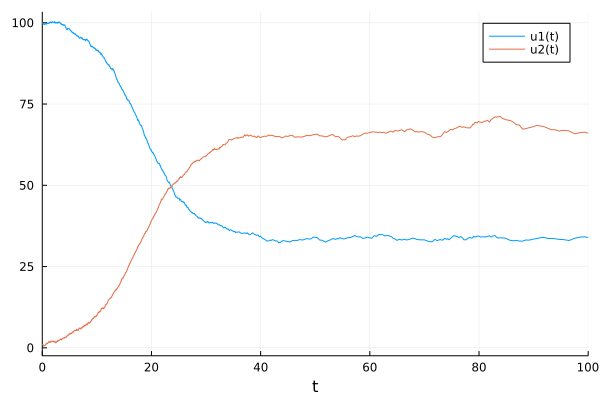

In [12]:
Random.seed!(4321)
g(U,θ,t) = θ.Σ*ones(2)
Θ = (α=α,β=β,Σ=0.5*I(2))
sprob = SDEProblem(f,g,last.(u0),tspan,Θ)
𝒰 = solve(sprob,callback=PositiveDomain())

plot(𝒰,fmt=:png)